In [26]:
import cv2 # computer vision
import numpy as np
import pandas as pd
import os # files 
import matplotlib.pyplot as plt

In [27]:
# extraction_path = r"D:\HARenv\human detection and people count\extraction_frames"
extraction_path=r"D:\HARenv\human detection and people count\frames_HAR"

In [28]:
# Path to the video file
video_path = r"D:\HARenv\multiPeopleHAR.mp4"
# video_path=r"D:\HARenv\Dataset\sitting\sitting5.mp4"
# Open the video file
cap = cv2.VideoCapture(video_path)

# Get the frames per second (fps) of the video
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the directory where frames will be saved
# extraction_path = r"D:\HARenv\human detection and people count\extraction_frames"
extraction_path=r"D:\HARenv\human detection and people count\frames_HAR"
# Initialize frame counter
frame_counter = 1

# Loop through the video frames
while True:
    ret, frame = cap.read()

    if not ret:
        break
    
    # Save the frame with a filename like "frame1.jpg" in the specified directory
    frame_filename = os.path.join(extraction_path, f'frame{frame_counter}.jpg')
    cv2.imwrite(frame_filename, frame)
    
    frame_counter += 1

# Release the video capture object
cap.release()

print(f"The frames per second (fps) of the video is: {fps}")

The frames per second (fps) of the video is: 25


In [18]:
print(frame_counter)

681


# (i) Object Detection and Bounding Boxes

# (ii) Counting People

# (iii) Screen Time Calculation


In [29]:
# yolov3 have single output layer for probability distribution and box predictions.
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
# weights - neural network parameters like bias,propagation etcc.
# cfg - configuration , architecture

In [30]:
# extraction_path=r"D:\HARenv\human detection and people count\extraction_frames"
extraction_path=r"D:\HARenv\human detection and people count\frames_HAR"

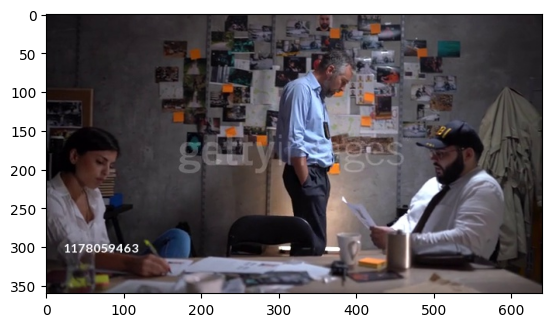

In [31]:
# img = plt.imread(r"D:\HARenv\human detection and people count\extraction_frames\frame20.jpg")   # reading image using its name
# plt.imshow(img)
img = plt.imread(r"D:\HARenv\human detection and people count\frames_HAR\frame20.jpg")   # reading image using its name
plt.imshow(img)


# Human detection

In [17]:
current_person_id = 0
printed_person_ids = set() # to keep track on already printed persons, set is used because of uniqueness
class_ids=[] # 0 for people in the model
data=[] # details of detected persons and their frames

for i in range(1, frame_counter):

    frame_path = extraction_path + "\\frame%d.jpg" % i
    image = cv2.imread(frame_path)
    height, width = image.shape[:2] # first 2 values in the image which is height and width

    # Preprocess the frames for YOLOv3
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
   # A pixel with a value of 0 is completely dark (black), while a pixel with a value of 255 is completely bright (white)
   # 0.00392: This is a scaling factor. It's used to scale pixel values ( adjusting pixel values in a image). In YOLOv3, 
   # images are usually preprocessed by dividing pixel values by 255.0, but this factor helps fine-tune the scaling and normalization
   # open cv loads BGR so swapRB=True
    
    net.setInput(blob) # sets input for the network

    # Get output
    outs = net.forward(net.getUnconnectedOutLayersNames()) # performs forward pass and gets the output.
    # outs =    [x1, y1, width1, height1, confidence1, class_id1]... for all layers 
    # outs - output layer
    
    # Thresholds
    conf_threshold = 0.8
    nms_threshold = 0

    confidences = []
    boxes = []

    # Detection process
    for out in outs: # iterate each output layer
        for detection in out:  # iterate each detected object in that output layer
            scores = detection[5:] # scores contains the confidence scores for different classes
            class_id = np.argmax(scores) # class_id with the highest confidence
            confidence = scores[class_id] # confidence score for class_id which may person,or object, person's class=0

            if confidence > conf_threshold and class_id == 0:  # checks confidence > threshold class_id = 0 means people
                center_x = int(detection[0] * width) # horizontal center Calculates the x-coordinate of the center of the bounding box in pixels.
                center_y = int(detection[1] * height) #  vertical center Calculates the y-coordinate of the center of the bounding box in pixels.
                w = int(detection[2] * width) # width
                h = int(detection[3] * height) # height
                x = int(center_x - w / 2) # x-coordinate top left corner of bounding box
                y = int(center_y - h / 2) # y-coordinate top left corner of bounding box

                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

                # class_ids (the class ID, which is 0 for people), confidences (the confidence score),
                # and boxes (the coordinates and dimensions of the bounding box). 
                # This data can be used for further processing or visualization of the detected people

    # Apply Non-Maximum Suppression (NMS)
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    # indices holds the indices of the bounding boxes that represent distinct and confident detections
    current_person_id = 0

    # Draw bounding boxes without tracking
    for index in indices:
        x, y, w, h = boxes[index]
        color = (0, 255, 0)  # Green color
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 3)
        
        # Increment the person ID
        current_person_id += 1 # tracking id

        # Append the data as a dictionary
        data.append({
            "Frame Name": f"frame{i}.jpg",
            "Person ID": current_person_id,
        })

        printed_person_ids.add(current_person_id)

    # Display the frame with bounding boxes
    resized_image = cv2.resize(image, (800, 600))
    cv2.imshow("Bounding box", resized_image)

    key = cv2.waitKey(1)

    if key == ord('q'):
        break

cv2.destroyAllWindows()

In [16]:
print("printed person id ",printed_person_ids)
print("class_id ",class_ids)
print("Data ",data)

printed person id  {1, 2, 3, 4}
class_id  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Counting people

In [18]:
print("total count of people is ",len(printed_person_ids)) # count total number of ids assigned

total count of people is  3


# Calculate screen time of each person

In [32]:
# WORST QUALITY
# from pytube import YouTube as yt
# video_link = "https://www.youtube.com/watch?v=9h2bKsJ7j_c"
# vid = yt(video_link)
# stream = vid.streams.first()
# stream.download()

In [145]:
df=pd.DataFrame(data)
df

,Frame Name,Person ID
0,frame1.jpg,1
1,frame1.jpg,2
2,frame1.jpg,3
3,frame1.jpg,4
4,frame1.jpg,5
...,...,...
1288,frame240.jpg,2
1289,frame240.jpg,3
1290,frame240.jpg,4
1291,frame240.jpg,5


In [9]:
# csv_file = 'data1.csv'

# # Save the DataFrame to a CSV file
# df.to_csv(csv_file, index=False)

data = pd.read_csv('data1.csv')

In [10]:
first_person = len(data[data['Person ID'] == 1])

# Count rows where Class is 'Both in the frame'
p2 = len(data[data['Person ID'] == 2])
p3 = len(data[data['Person ID'] == 3])
p4 = len(data[data['Person ID'] == 4])
p5 = len(data[data['Person ID'] == 5])
p6 = len(data[data['Person ID'] == 6])
p7 = len(data[data['Person ID'] == 7])
p8 = len(data[data['Person ID'] == 8])


print(f"Count of 'person 1': {first_person} frames ")
print(f"Count of 'person 2': {p2} frames" )
print(f"Count of 'person 3': {p3} frames" )
print(f"Count of 'person 4': {p4} frames" )
print(f"Count of 'person 5': {p5} frames" )
print(f"Count of 'person 6': {p6} frames" )
print(f"Count of 'person 7': {p7} frames" )
print(f"Count of 'person 8': {p8} frames" )

Count of 'person 1': 240 frames 
Count of 'person 2': 240 frames
Count of 'person 3': 240 frames
Count of 'person 4': 240 frames
Count of 'person 5': 209 frames
Count of 'person 6': 104 frames
Count of 'person 7': 19 frames
Count of 'person 8': 1 frames


In [11]:

first_person/fps

10.0

Activity recognition

In [9]:
from tensorflow.keras.models import load_model
model = load_model("D:\\HARenv\\HAR_officeActivity")
# model = load_model(r"D:\HARenv\best_model.h5")

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 60, 60, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 64)        0         
 D)                                                              
                                                                 
 global_average_pooling2d (  (None, 64)                0         
 GlobalAveragePooling2D)                                         
                                                        

In [11]:
from tensorflow.keras.models import load_model
# model = load_model("D:\\HARenv\\HAR_officeActivity")
model_2 = load_model(r"D:\HARenv\best_model.h5")

In [12]:
model_2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [55]:
from tensorflow.keras.models import load_model

activity_class_names = ['sitting', 'walking', 'sitting', 'standing', 'typing', 'walking', 'writing']

current_person_id = 0
printed_person_ids = set()  # to keep track of already printed persons, set is used because of uniqueness
class_ids = []  # 0 for people in the model
data = []  # details of detected persons and their frames

# Load your trained activity recognition model
model = load_model("D:\\HARenv\\HAR_officeActivity")
activity_recognition_model = model

for i in range(1, frame_counter):
    if i % 15 == 0:
        frame_path = extraction_path + "\\frame%d.jpg" % i
        image = cv2.imread(frame_path)
        height, width = image.shape[:2]

        # Preprocess the frames for YOLOv3
        blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)

        # Get output
        outs = net.forward(net.getUnconnectedOutLayersNames())

        # Thresholds
        conf_threshold = 0.9  # Increase confidence threshold
        nms_threshold = 0.3

        confidences = []
        boxes = []

        # Detection process
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]

                if confidence > conf_threshold and class_id == 0:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    class_ids.append(class_id)
                    confidences.append(float(confidence))
                    boxes.append([x, y, w, h])

        # Apply Non-Maximum Suppression (NMS)
        indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

        current_person_id = 0

        for index in indices:
            x, y, w, h = boxes[index]
            color = (0, 255, 0)  # Green color

            # Crop the ROI (Region of Interest) based on the bounding box
            roi = image[y:y + h, x:x + w]

            current_person_id += 1  # Tracking id

            try:
                # Resize the ROI
                roi = cv2.resize(roi, (64, 64))
                roi = roi / 255.0  # Normalize to [0, 1]
            except cv2.error as e:
                # Handle the error (empty image) here
                print(f"Error resizing ROI: {e}")
                continue

            # Make a prediction using your activity recognition model
            activity_predictions = activity_recognition_model.predict(np.expand_dims(roi, axis=0))

            # Get the predicted activity class with the highest probability
            predicted_activity_class = np.argmax(activity_predictions)

            # Reduce boundary box thickness and text size
            box_thickness = 1  # Decrease box thickness
            text_scale = 0.5  # Decrease text size

            # Draw the bounding box
            cv2.rectangle(image, (x, y), (x + w, y + h), color, box_thickness)

            # Define text settings
            activity_class = activity_class_names[predicted_activity_class]  # Get the activity class
            text = f"Person {current_person_id}, Activity: {activity_class}"

            font = cv2.FONT_HERSHEY_SIMPLEX
            font_color = (0, 0, 255)  # Red color

            # Get the size of the text
            (text_width, text_height), _ = cv2.getTextSize(text, font, text_scale, box_thickness)

            # Calculate the position for the text to be centered in the bounding box
            text_x = x + (w - text_width) // 2
            text_y = y - 5  # Slightly above the top of the bounding box

            # Display the text with the specified settings
            cv2.putText(image, text, (text_x, text_y), font, text_scale, font_color, box_thickness)

            # Append the data as a dictionary
            data.append({
                "Frame Name": f"frame{i}.jpg",
                "Person ID": current_person_id,
                "Predicted Activity Class": activity_class,  # Include the activity class in the data
            })

        # Display the frame with bounding boxes
        resized_image = cv2.resize(image, (800, 600))
        cv2.imshow("Bounding box", resized_image)

        key = cv2.waitKey(100)
        if key == ord('q'):
            break
cv2.destroyAllWindows()

1/1 [==============================] - 0s 29ms/step
Error resizing ROI: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

1/1 [==============================] - 0s 24ms/step
Error resizing ROI: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

1/1 [==============================] - 0s 25ms/step
Error resizing ROI: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

1/1 [==============================] - 0s 25ms/step
Error resizing ROI: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

1/1 [==============================] - 0s 27ms/step
